In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [28]:
energy_df = pd.read_csv(
    '/Users/viewyan/fairchem/src/fairchem/data/odac/promising_mof/promising_mof_energies/adsorption_energy.txt',
    sep=' ',
    header=None,
    names=['mof_id', 'adsorption_energy']
)

features_df = pd.read_csv(
    '/Users/viewyan/fairchem/src/fairchem/data/odac/promising_mof/promising_mof_features/output.txt',
    sep='\t'
)


In [29]:
features_df = pd.read_csv('/Users/viewyan/fairchem/src/fairchem/data/odac/promising_mof/promising_mof_features/output.txt', sep='\t')
energy_df = pd.read_csv('/Users/viewyan/fairchem/src/fairchem/data/odac/promising_mof/promising_mof_energies/adsorption_energy.txt',
                        sep=' ', header=None, names=['mof_id', 'adsorption_energy'])


features_df['Material'] = features_df['Material'].str.replace('.cif', '', regex=False)


energy_df['Material'] = energy_df['mof_id'].apply(lambda x: x.split('_w_')[0])


merged_df = pd.merge(energy_df, features_df, on='Material', how='inner')


print(merged_df.head())
print(f"Total number of matched samples：{len(merged_df)}")

# 保存训练用的合并数据（可选）
merged_df.to_csv('dac2023_training_data.csv', index=False)

                       mof_id  adsorption_energy       Material  ID  \
0  REDROI_0.08_0_w_CO2_2H2O_1          -1.710965  REDROI_0.08_0   4   
1  REDROI_0.08_0_w_CO2_2H2O_2          -1.419234  REDROI_0.08_0   4   
2  REDROI_0.08_0_w_CO2_2H2O_3          -1.408311  REDROI_0.08_0   4   
3       REDROI_0.08_0_w_CO2_1          -0.542461  REDROI_0.08_0   4   
4       REDROI_0.08_0_w_CO2_2          -0.550568  REDROI_0.08_0   4   

                     CF  M_O_M  Benzene  Parellel  Parellel68  \
0  H_25_C_44_O_24_Zn_10      1        1         1           1   
1  H_25_C_44_O_24_Zn_10      1        1         1           1   
2  H_25_C_44_O_24_Zn_10      1        1         1           1   
3  H_25_C_44_O_24_Zn_10      1        1         1           1   
4  H_25_C_44_O_24_Zn_10      1        1         1           1   

   DistanceParallel68  DistanceParallel68Direct  uncoordN  Unnamed: 10  
0            7.241507                  8.426583         0          NaN  
1            7.241507               

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


X = merged_df[['M_O_M', 'Benzene', 'Parellel', 'Parellel68',
               'DistanceParallel68', 'DistanceParallel68Direct', 'uncoordN']]
y = merged_df['adsorption_energy']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🌟 Mean Absolute Error (MAE): {mae:.4f}")
print(f"🌟 R² Score: {r2:.4f}")

🌟 Mean Absolute Error (MAE): 0.2995
🌟 R² Score: -0.0565


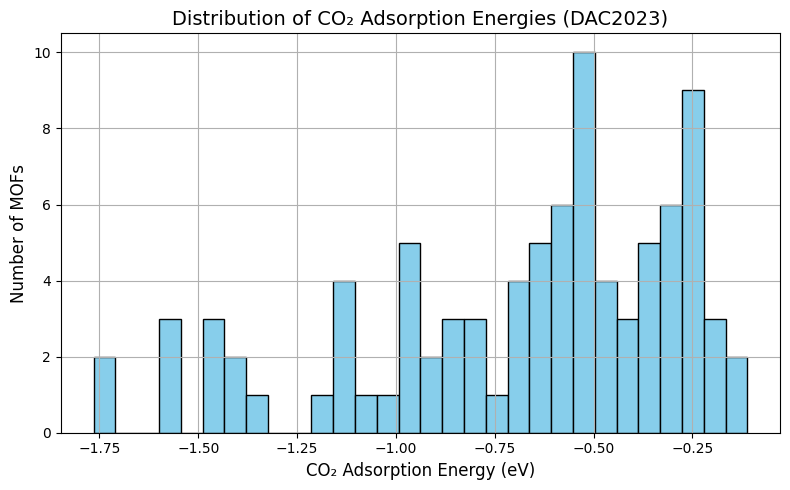

In [32]:
plt.figure(figsize=(8, 5))
plt.hist(merged_df['adsorption_energy'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("CO₂ Adsorption Energy (eV)", fontsize=12)
plt.ylabel("Number of MOFs", fontsize=12)
plt.title("Distribution of CO₂ Adsorption Energies (DAC2023)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
features_df['Material'] = features_df['Material'].str.replace('.cif', '', regex=False)
energy_df['Material'] = energy_df['mof_id'].apply(lambda x: x.split('_w_')[0])
merged_df = pd.merge(energy_df, features_df, on='Material', how='inner')
print(f"✅ Matched samples: {len(merged_df)}")

✅ Matched samples: 89


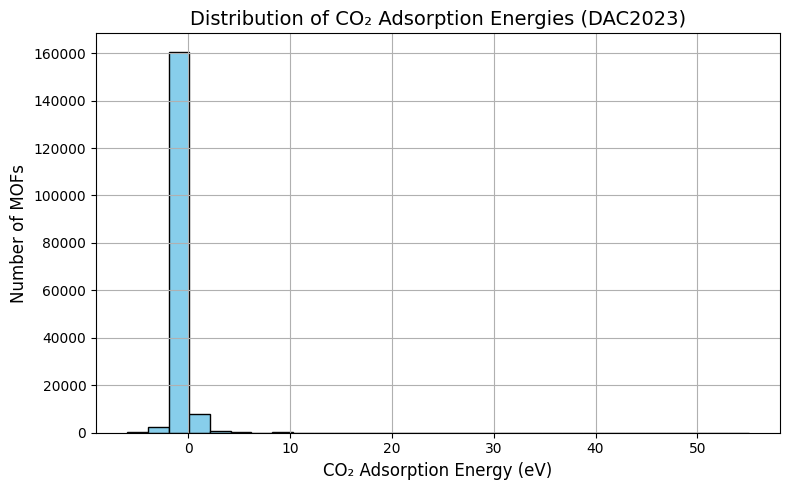

In [6]:
plt.figure(figsize=(8, 5))
plt.hist(energy_df['adsorption_energy'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("CO₂ Adsorption Energy (eV)", fontsize=12)
plt.ylabel("Number of MOFs", fontsize=12)
plt.title("Distribution of CO₂ Adsorption Energies (DAC2023)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
from matminer.featurizers.structure import DensityFeatures
from pymatgen.core import Structure
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pymatgen.io.cif")


cif_folder = "/Users/viewyan/fairchem/src/fairchem/data/odac/promising_mof/promising_mof_structures/pristine"

# 准备结构
structures, ids = [], []
for f in os.listdir(cif_folder):
    if f.endswith(".cif"):
        try:
            s = Structure.from_file(os.path.join(cif_folder, f))
            structures.append(s)
            ids.append(f.replace(".cif", ""))
        except: pass


featurizers = [
    DensityFeatures()
]


data, columns = [], []
for sid, struct in zip(ids, structures):
    row = [sid]
    skip = False
    for f in featurizers:
        try:
            feats = f.featurize(struct)
            row += feats
            if not columns:
                columns += f.feature_labels()
        except:
            skip = True
            break
    if not skip:
        data.append(row)

df = pd.DataFrame(data, columns=["mof_id"] + columns)
df.to_csv("dac23_stable_fingerprints.csv", index=False)
print(f"✅ Total number of matched samples：{len(df)}")

✅ Total number of matched samples：135


In [10]:
df_energy = pd.read_csv(
    "/Users/viewyan/fairchem/src/fairchem/data/odac/promising_mof/promising_mof_energies/adsorption_energy.txt",
    sep="\s+",
    header=None,
    names=["mof_id", "adsorption_energy"]
)
print(df_energy.head())

                       mof_id  adsorption_energy
0  EWESAC_0.03_0_w_CO2_2H2O_1          -1.197873
1  LUVTAY_0.03_1_w_CO2_2H2O_1          -0.998965
2  LUVTAY_0.03_1_w_CO2_2H2O_2          -0.790048
3  LUVTAY_0.03_1_w_CO2_2H2O_3          -0.639308
4  LUVTAY_0.03_1_w_CO2_2H2O_4          -0.570788


In [11]:
df_energy["structure"] = df_energy["mof_id"].str.extract(r"^([A-Z0-9]+)")

# 再 merge
df_all = pd.merge(df_energy, df, left_on="structure", right_on="mof_id")
print(f"✅ Total number of matched samples：{len(df_all)}")

✅ Total number of matched samples：4239


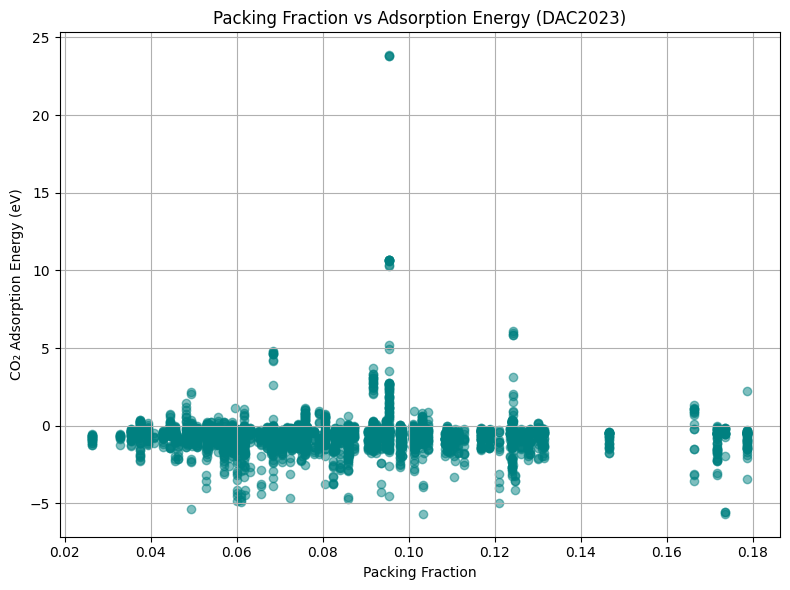

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(df_all["packing fraction"], df_all["adsorption_energy"], alpha=0.5, color='teal')
plt.xlabel("Packing Fraction")
plt.ylabel("CO₂ Adsorption Energy (eV)")
plt.title("Packing Fraction vs Adsorption Energy (DAC2023)")
plt.grid(True)
plt.tight_layout()
plt.show()

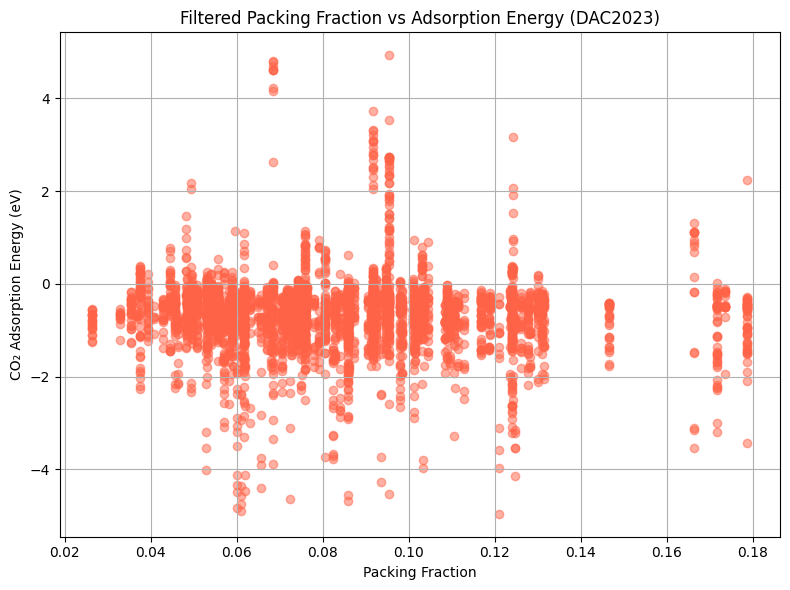

In [15]:
df_clean = df_all[(df_all["adsorption_energy"] > -5) & (df_all["adsorption_energy"] < 5)]
plt.figure(figsize=(8, 6))
plt.scatter(df_clean["packing fraction"], df_clean["adsorption_energy"], alpha=0.5, color='tomato')
plt.xlabel("Packing Fraction")
plt.ylabel("CO₂ Adsorption Energy (eV)")
plt.title("Filtered Packing Fraction vs Adsorption Energy (DAC2023)")
plt.grid(True)
plt.tight_layout()
plt.show()

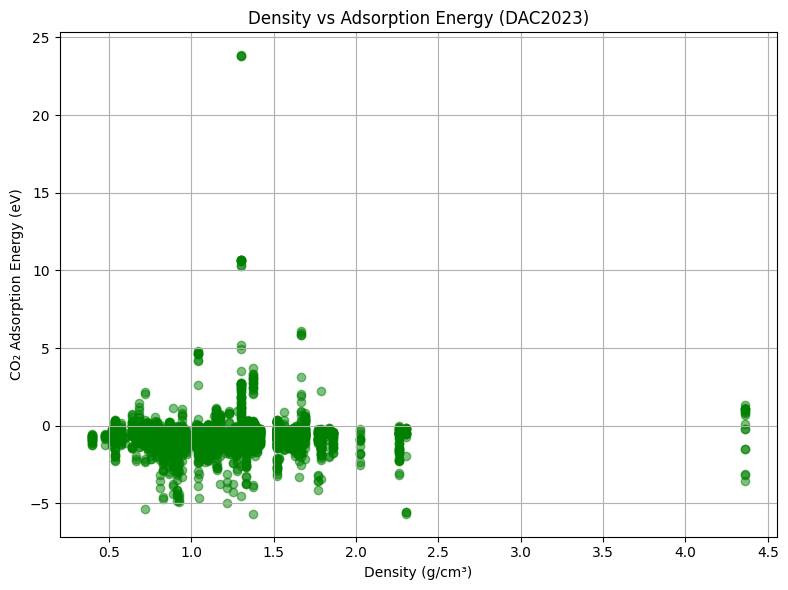

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(df_all["density"], df_all["adsorption_energy"], alpha=0.5, color="green")
plt.xlabel("Density (g/cm³)")
plt.ylabel("CO₂ Adsorption Energy (eV)")
plt.title("Density vs Adsorption Energy (DAC2023)")
plt.grid(True)
plt.tight_layout()
plt.show()

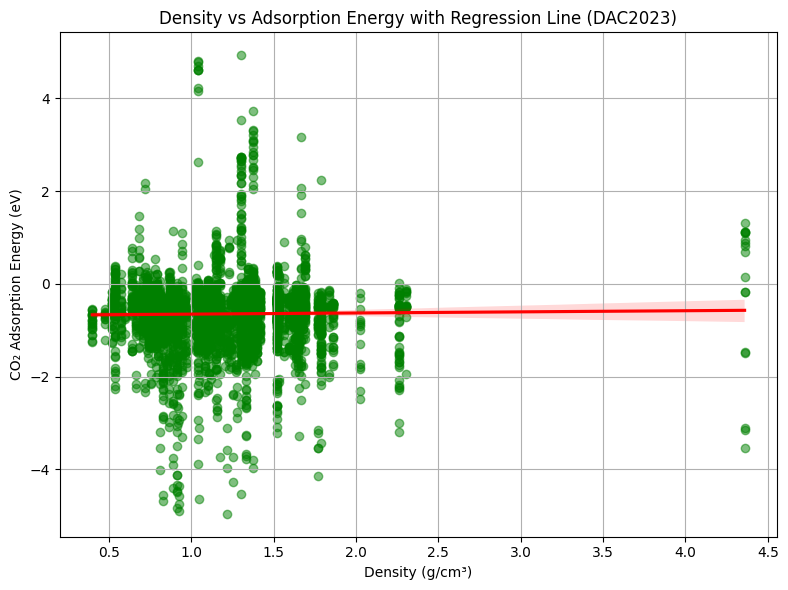

In [19]:
df_filtered = df_all[(df_all["adsorption_energy"] >= -5) & (df_all["adsorption_energy"] <= 5)]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_filtered,
    x="density",
    y="adsorption_energy",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
    color="green"
)

plt.xlabel("Density (g/cm³)")
plt.ylabel("CO₂ Adsorption Energy (eV)")
plt.title("Density vs Adsorption Energy with Regression Line (DAC2023)")
plt.tight_layout()
plt.grid(True)
plt.show()

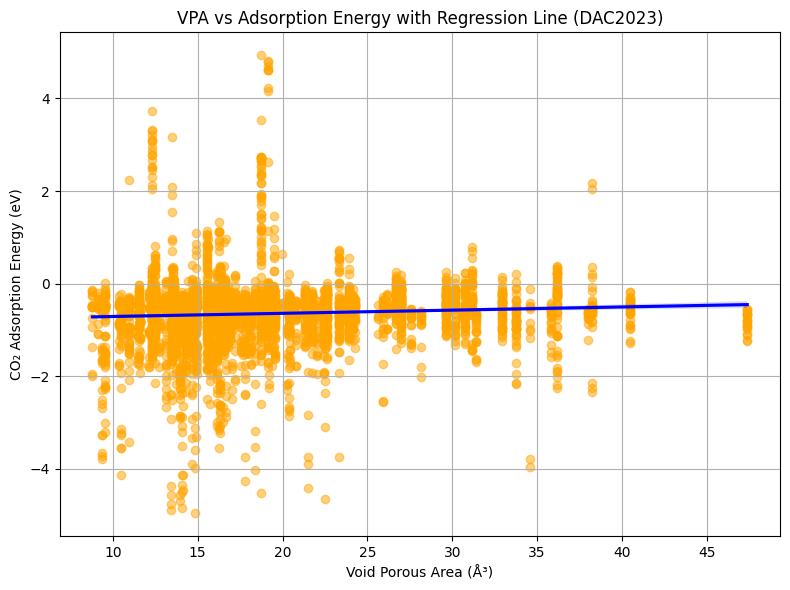

In [20]:
df_filtered = df_all[(df_all["adsorption_energy"] >= -5) & (df_all["adsorption_energy"] <= 5)]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_filtered,
    x="vpa",
    y="adsorption_energy",
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "blue"},
    color="orange"
)

plt.xlabel("Void Porous Area (Å³)")
plt.ylabel("CO₂ Adsorption Energy (eV)")
plt.title("VPA vs Adsorption Energy with Regression Line (DAC2023)")
plt.tight_layout()
plt.grid(True)
plt.show()


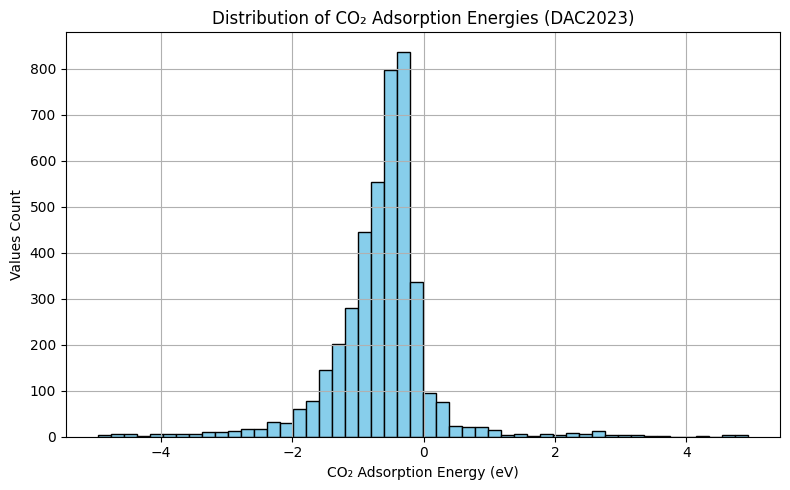

In [21]:
import matplotlib.pyplot as plt

df_filtered = df_all[(df_all["adsorption_energy"] >= -5) & (df_all["adsorption_energy"] <= 5)]

# 绘图
plt.figure(figsize=(8, 5))
plt.hist(df_filtered["adsorption_energy"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of CO₂ Adsorption Energies (DAC2023)")
plt.xlabel("CO₂ Adsorption Energy (eV)")
plt.ylabel("Values Count")
plt.grid(True)
plt.tight_layout()
plt.show()


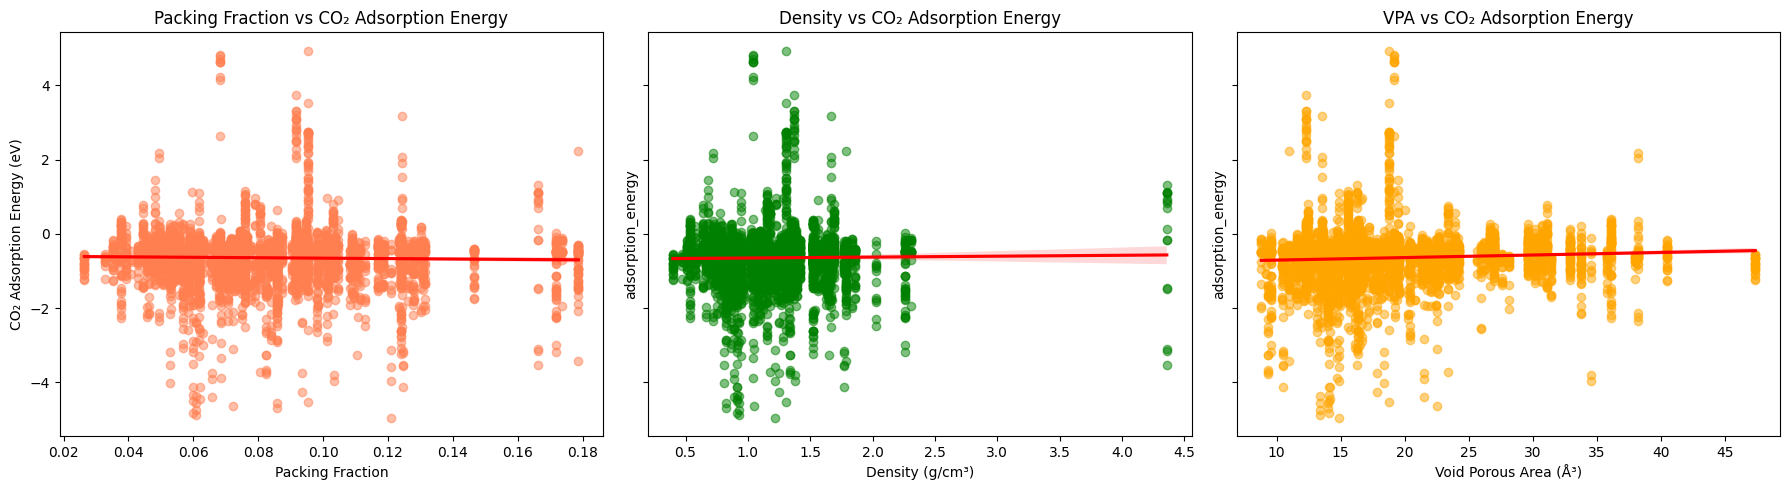

In [25]:
df_filtered = df_all[(df_all["adsorption_energy"] >= -5) & (df_all["adsorption_energy"] <= 5)]

# 图布局
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Packing Fraction
sns.regplot(data=df_filtered, x="packing fraction", y="adsorption_energy", ax=axs[0],
            scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, color="coral")
axs[0].set_title("Packing Fraction vs CO₂ Adsorption Energy")
axs[0].set_xlabel("Packing Fraction")
axs[0].set_ylabel("CO₂ Adsorption Energy (eV)")

# Density
sns.regplot(data=df_filtered, x="density", y="adsorption_energy", ax=axs[1],
            scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, color="green")
axs[1].set_title("Density vs CO₂ Adsorption Energy")
axs[1].set_xlabel("Density (g/cm³)")

# VPA
sns.regplot(data=df_filtered, x="vpa", y="adsorption_energy", ax=axs[2],
            scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, color="orange")
axs[2].set_title("VPA vs CO₂ Adsorption Energy")
axs[2].set_xlabel("Void Porous Area (Å³)")

plt.tight_layout()
plt.show()
